In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from sbi.inference import NPE
from sbi.analysis import pairplot

/Users/tsyamamoto/miniforge3/envs/sbi_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def damped_sinusoid(t, amp, f0, tau, phi):
    return amp * torch.exp(-t / tau) * torch.cos(2.0 * np.pi * f0 * t + phi)

def simulator(signal, noisevar):
    return signal + torch.randn_like(signal) * np.sqrt(noisevar)

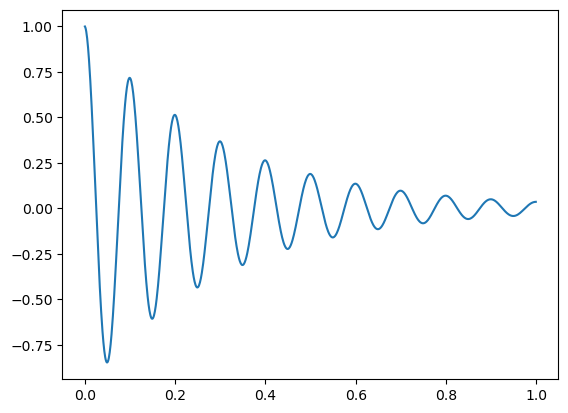

In [3]:
params = {
    'amp': 1.0,
    'f0': 10.0,
    'tau': 0.3,
    'phi': 0.0
}

n_tsample = 1000
t = torch.arange(n_tsample, dtype=torch.float) / n_tsample
signal = damped_sinusoid(t, **params)

plt.figure()
plt.plot(t, signal)
plt.show()

In [4]:
# Generate training data
n_trainsample = 10000
train_x = torch.zeros((n_trainsample, n_tsample), dtype=torch.float)
train_theta = torch.zeros((n_trainsample, 2), dtype=torch.float)
for j in range(n_trainsample):
    params = {
        'amp': 1.0,
        'f0': np.random.uniform(10, 20),
        'tau': np.random.uniform(0.1, 0.3),
        'phi': 0.0
    }
    train_theta[j, 0] = params['f0']
    train_theta[j, 1] = params['tau']
    signal = damped_sinusoid(t, **params)
    train_x[j] = simulator(signal, 0.01)

In [5]:
# choose sbi method and train
inference = NPE()
inference.append_simulations(train_theta, train_x).train();

 Neural network successfully converged after 24 epochs.

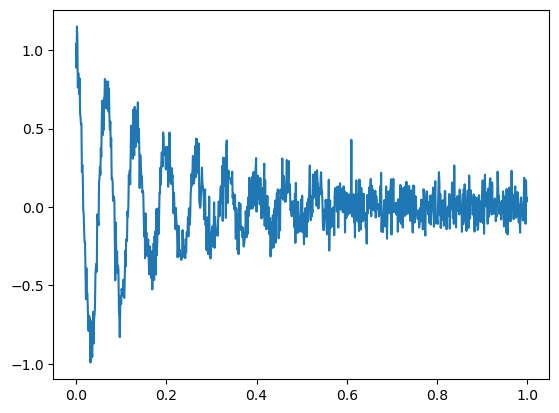

In [6]:
# Test data
params = {
    'amp': 1.0,
    'f0': 15.0,
    'tau': 0.2,
    'phi': 0.0
}
signal = damped_sinusoid(t, **params)
observation = simulator(signal, 0.01)

plt.figure()
plt.plot(t, observation)
plt.show()

In [7]:
ndraw = 10000
posterior = inference.build_posterior()
samples = posterior.sample((ndraw,), x=observation)

Drawing 10000 posterior samples: 100%|██████████| 10000/10000 [00:00<00:00, 108360.91it/s]


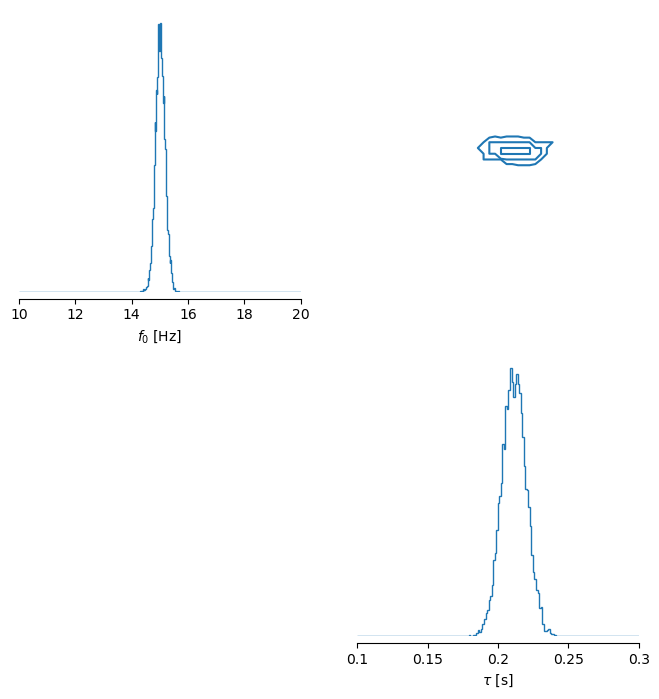

In [8]:
pairplot(
    samples,
    figsize=(8, 8),
    limits=[[10, 20], [0.1, 0.3]],
    upper="contour",
    labels=[r"$f_0$ [Hz]", r"$\tau$ [s]"],
    # colors=['blue', 'orange']
);